In [45]:
import numpy as np
import scipy as sp
import scipy.io
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.distributions.transforms as transform
from IPython.display import HTML
import math
import os

# very high precision
torch.set_default_dtype(torch.float64)

import torch.optim as optim

# return to original code: https://github.com/acids-ircam/pytorch_flows/blob/master/flows_04.ipynb

# use normalizing flow as correction
# cite: https://github.com/acids-ircam/pytorch_flows/blob/master/flows_04.ipynb
class Flow(transform.Transform, nn.Module):
    
    def __init__(self):
        transform.Transform.__init__(self)
        nn.Module.__init__(self)
    
    # Init all parameters
    def init_parameters(self):
        for param in self.parameters():
            # use random parameters
            param.data.uniform_(-0.01, 0.01)
            
    # Hacky hash bypass
    def __hash__(self):
        return nn.Module.__hash__(self)
    
    # forward evaluation: x = f(z)
    def forward(self, z):
        pass

# Main class for normalizing flow
class NormalizingFlow(nn.Module):
    def __init__(self, dim, blocks, flow_length, density):
        super().__init__()
        biject = []
        for f in range(flow_length):
            if blocks is None:
                # by default uses Planar flow, which does not have inverse abiity
                biject.append(PlanarFlow(dim))
            else:
                # alternate among the blocks
                for flow in blocks:
                    biject.append(flow(dim))
        self.transforms = transform.ComposeTransform(biject)
        self.bijectors = nn.ModuleList(biject)
        self.base_density = density
        self.log_det = []

    def forward(self, z):
        self.log_det = []
        # Applies series of flows
        for b in range(len(self.bijectors)):
            self.log_det.append(self.bijectors[b].log_abs_det_jacobian(z))
            z = self.bijectors[b](z)
        return z, self.log_det


class PlanarFlow(Flow):

    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.init_parameters()

    def _call(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        return z + self.scale * torch.tanh(f_z)

    def log_abs_det_jacobian(self, z):
        f_z = F.linear(z, self.weight, self.bias)
        psi = (1 - torch.tanh(f_z) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return torch.log(det_grad.abs() + 1e-9)

# Affine coupling flow
class AffineCouplingFlow(Flow):
    def __init__(self, dim, n_hidden=64, n_layers=3, activation=nn.ReLU):
        super(AffineCouplingFlow, self).__init__()
        self.k = dim // 2
        self.g_mu = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.g_sig = self.transform_net(self.k, dim - self.k, n_hidden, n_layers, activation)
        self.init_parameters()
        self.bijective = True

    def transform_net(self, nin, nout, nhidden, nlayer, activation):
        net = nn.ModuleList()
        for l in range(nlayer):
            net.append(nn.Linear(l==0 and nin or nhidden, l==nlayer-1 and nout or nhidden))
            net.append(activation())
        return nn.Sequential(*net)
        
    def _call(self, z):
        z_k, z_D = z[:, :self.k], z[:, self.k:]
        zp_D = z_D * torch.exp(self.g_sig(z_k)) + self.g_mu(z_k)
        return torch.cat((z_k, zp_D), dim = 1)

    def _inverse(self, z):
        zp_k, zp_D = z[:, :self.k], z[:, self.k:]
        z_D = (zp_D - self.g_mu(zp_k)) / self.g_sig(zp_k)
        return torch.cat((zp_k, z_D))

    def log_abs_det_jacobian(self, z):
        z_k = z[:, :self.k]
        return -torch.sum(torch.abs(self.g_sig(z_k)))
    

class ReverseFlow(Flow):

    def __init__(self, dim):
        super(ReverseFlow, self).__init__()
        self.permute = torch.arange(dim-1, -1, -1)
        self.inverse = torch.argsort(self.permute)

    def _call(self, z):
        return z[:, self.permute]

    def _inverse(self, z):
        return z[:, self.inverse]

    def log_abs_det_jacobian(self, z):
        return torch.zeros(z.shape[0], 1)
    
class ShuffleFlow(ReverseFlow):

    def __init__(self, dim):
        super(ShuffleFlow, self).__init__(dim)
        self.permute = torch.randperm(dim)
        self.inverse = torch.argsort(self.permute)
    
    
class BatchNormFlow(Flow):

    def __init__(self, dim, momentum=0.95, eps=1e-5):
        super(BatchNormFlow, self).__init__()
        # Running batch statistics
        self.r_mean = torch.zeros(dim)
        self.r_var = torch.ones(dim)
        # Momentum
        self.momentum = momentum
        self.eps = eps
        # Trainable scale and shift (cf. original paper)
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))
        
    def _call(self, z):
        if self.training:
            # Current batch stats
            self.b_mean = z.mean(0)
            self.b_var = (z - self.b_mean).pow(2).mean(0) + self.eps
            # Running mean and var
            self.r_mean = self.momentum * self.r_mean + ((1 - self.momentum) * self.b_mean)
            self.r_var = self.momentum * self.r_var + ((1 - self.momentum) * self.b_var)
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - mean) / var.sqrt()
        y = self.gamma * x_hat + self.beta
        return y

    def _inverse(self, x):
        if self.training:
            mean = self.b_mean
            var = self.b_var
        else:
            mean = self.r_mean
            var = self.r_var
        x_hat = (z - self.beta) / self.gamma
        y = x_hat * var.sqrt() + mean
        return y
        
    def log_abs_det_jacobian(self, z):
        # Here we only need the variance
        mean = z.mean(0)
        var = (z - mean).pow(2).mean(0) + self.eps
        log_det = torch.log(self.gamma) - 0.5 * torch.log(var + self.eps)
        return torch.sum(log_det, -1)
    



In [46]:
# load sample data
data_ginz = scipy.io.loadmat("./data/legendre_tt_irt_ginzburg2d_sample.mat")
display(data_ginz.keys())
# very high precision
torch.set_default_dtype(torch.float64)

dict_keys(['__header__', '__version__', '__globals__', 'A', 'C', 'L', 'M', 'Ns', 'R', 'X', 'X_bad', 'X_bad_test', 'X_bad_train', 'X_test', 'X_train', 'ans', 'beta', 'coeff_tt', 'cov_samp', 'd', 'delta', 'dx', 'None', 'exact_variance', 'f_', 'legendre_ord', 'likes', 'likes_bad', 'likes_bad_test', 'likes_bad_train', 'likes_test', 'likes_train', 'mu_samp', 'n', 'new_X', 'p', 's', 'snake', 'temp', 'tmp', 'xg', '__function_workspace__'])

In [47]:
# training data from truncated TT and compare with Gaussian
use_gaussian_prior = True
if use_gaussian_prior:
    training_data = data_ginz['X_bad_train'].T
    test_data = data_ginz['X_bad_test'].T
    log_training_data_densities = np.log(data_ginz['likes_bad_train'])
    log_test_data_densities = np.log(data_ginz['likes_bad_test'])
else:
    training_data = data_ginz['X_train'].T
    test_data = data_ginz['X_test'].T
    log_training_data_densities = np.log(data_ginz['likes_train'])
    log_test_data_densities = np.log(data_ginz['likes_test'])
# training data (Gaussian)
print("====== shape of training data = {}".format(training_data.shape))
num_samples = training_data.shape[0]
ginz_dim = training_data.shape[1]
# parameters
temperature = data_ginz['temp'][0][0]
ginz_delta = data_ginz['delta'][0][0]
scale = data_ginz['R'][0][0]

====== shape of training data = (2500, 64)


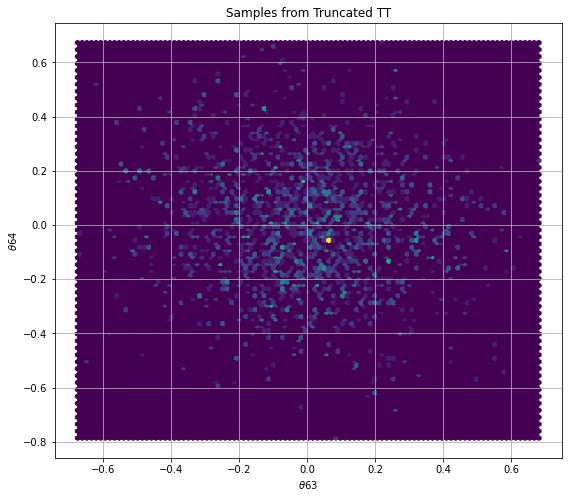

In [48]:
# set random seed
np.random.seed(10)
data_idx = np.random.randint(0, training_data.shape[0], num_samples)
plt.figure(figsize=(20,8));
plt.subplot(1,2,1); plt.grid(True); 
plt.xlabel("$\\theta {}$".format(ginz_dim-1)); 
plt.ylabel("$\\theta {}$".format(ginz_dim)); 
plt.title("Samples from Truncated TT"); 
plot_data_trunc = training_data[data_idx, :]
# it should look like two modes
plt.hexbin(plot_data_trunc[:,ginz_dim-2], plot_data_trunc[:,ginz_dim-1]);

In [49]:
# helper functions
def ginzburg_landau_energy2d(U, delta=ginz_delta):
    """ computes the GL energy (1d) for U, U is an torch.Tensor of shape N x d. 
    
    Outputs energy as shape (N x 1) tensor
    
    """
    # make row vector
    U = torch.Tensor(U)
    N = U.shape[0]
    d = U.shape[1]
    # dimension must be a perfect square
    board_dim = int(math.sqrt(d) + 0.5) # spatial dimension, instead of the PDF dimension
    assert board_dim**2 == d, "dimension is not a perfect square"
    # compute stepsize
    h = 1 / (board_dim+1)
    # torch reshape is different from MATLAB reshape
    # MATLAB is by column, torch is by row
    # we use MATLAB's format here, so need to transpose the result of torch.reshape
    U_2d = U.reshape([N, board_dim, board_dim])
    U_2d = torch.transpose(U_2d, 1, 2)
    # add boundary values
    U_2d_save = U_2d.clone()
    U_2d = torch.zeros([N, board_dim+2, board_dim+2]) # including U0, Ud+1
    U_2d[:,1:board_dim+1,1:board_dim+1] = U_2d_save
    # (u(x,y), x = 0, x = 1)
    U_2d[:, 0, :] = 1
    U_2d[:, -1, :] = 1
    # (u(x,y), y = 0, y = 1)
    U_2d[:, :, 0] = -1
    U_2d[:, :, -1] = -1
    # compute energy with U_0 and U_d+1
    u_x = (1 / h) * (U_2d[:, 1:board_dim+2, :] - U_2d[:, 0:board_dim+1, :])
    u_y = (1 / h) * (U_2d[:, :, 1:board_dim+2] - U_2d[:, :, 0:board_dim+1])
    V = (delta/2)*( (u_x**2).sum([1,2]) ) + \
     (delta/2) * ( (u_y**2).sum([1,2]) ) + \
    (1/(4*delta)) * ((1 - U_2d ** 2) ** 2).sum([1,2])
    return V

def equilibrium_pdf(U, delta=ginz_delta, beta=1/temperature):
    V = ginzburg_landau_energy2d(scale*U, delta)
    prob = torch.exp(-beta * V)
    return prob


def loss_kl_3(log_prior_distrib, targ_distrib, z0, zk, log_jacobians):
    """ same as LOSS_KL() but:
        - log_prior_distrib is predetermined as passed in as a torch.Tensor
        - targ_distrib is callable, rather than PyTorch distribution. 
    """
    sum_of_log_jacobians = sum(log_jacobians)
    return (log_prior_distrib - sum_of_log_jacobians + \
            (1 / temperature) * ginzburg_landau_energy2d(scale * zk)).mean()

```python
print("===== testing ginzburg_landau_energy2d\n")
print(ginzburg_landau_energy2d(torch.rand([2**15,100])))

print("===== testing equilibrium probability density\n")
print(equilibrium_pdf(torch.rand([2**15,100])))

```

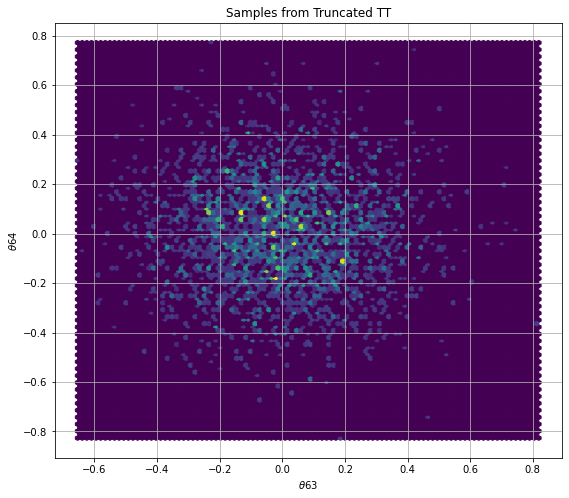

In [50]:
# set random seed
data_idx = np.random.randint(0, num_samples, 100*num_samples)
plt.figure(figsize=(20,8));
plt.subplot(1,2,1); plt.grid(True); 
plt.xlabel("$\\theta {}$".format(ginz_dim-1)); 
plt.ylabel("$\\theta {}$".format(ginz_dim)); 
plt.title("Samples from Truncated TT"); 
plot_data_trunc = training_data[data_idx, :]
# plotting the last dimension, should look like two modes
plt.hexbin(plot_data_trunc[:,13], plot_data_trunc[:,14]);

(Epoch 0, Batch 0) Negtive Log-Likelihood Training Err: 94.07871851213358
(Epoch 0, Batch 0) Negtive Log-Likelihood Generalization Err: 94.70862260130497
(Epoch 0, Batch 5) Negtive Log-Likelihood Training Err: 94.55903652674323
(Epoch 0, Batch 5) Negtive Log-Likelihood Generalization Err: 94.5785668743193
(Epoch 1, Batch 0) Negtive Log-Likelihood Training Err: 94.52410095574118
(Epoch 1, Batch 0) Negtive Log-Likelihood Generalization Err: 94.35480781883172
(Epoch 1, Batch 5) Negtive Log-Likelihood Training Err: 94.3446909599896
(Epoch 1, Batch 5) Negtive Log-Likelihood Generalization Err: 93.99014170057748
(Epoch 2, Batch 0) Negtive Log-Likelihood Training Err: 93.28029706346572
(Epoch 2, Batch 0) Negtive Log-Likelihood Generalization Err: 93.4424015028451
(Epoch 2, Batch 5) Negtive Log-Likelihood Training Err: 92.69090826162608
(Epoch 2, Batch 5) Negtive Log-Likelihood Generalization Err: 92.65557404450249
(Epoch 3, Batch 0) Negtive Log-Likelihood Training Err: 91.77249176282703
(Epoc

(Epoch 26, Batch 5) Negtive Log-Likelihood Training Err: 76.97833384852302
(Epoch 26, Batch 5) Negtive Log-Likelihood Generalization Err: 79.59617846208955
(Epoch 27, Batch 0) Negtive Log-Likelihood Training Err: 76.72960341050552
(Epoch 27, Batch 0) Negtive Log-Likelihood Generalization Err: 79.59200932848961
(Epoch 27, Batch 5) Negtive Log-Likelihood Training Err: 77.19254031792983
(Epoch 27, Batch 5) Negtive Log-Likelihood Generalization Err: 79.58466438090782
(Epoch 28, Batch 0) Negtive Log-Likelihood Training Err: 76.32783503144722
(Epoch 28, Batch 0) Negtive Log-Likelihood Generalization Err: 79.59542609494224
(Epoch 28, Batch 5) Negtive Log-Likelihood Training Err: 76.82280443585594
(Epoch 28, Batch 5) Negtive Log-Likelihood Generalization Err: 79.6260269321181
(Epoch 29, Batch 0) Negtive Log-Likelihood Training Err: 77.20146447184453
(Epoch 29, Batch 0) Negtive Log-Likelihood Generalization Err: 79.5822781914602
(Epoch 29, Batch 5) Negtive Log-Likelihood Training Err: 76.179405

(Epoch 53, Batch 0) Negtive Log-Likelihood Training Err: 75.56816694994103
(Epoch 53, Batch 0) Negtive Log-Likelihood Generalization Err: 79.7046978999772
(Epoch 53, Batch 5) Negtive Log-Likelihood Training Err: 75.17932845105608
(Epoch 53, Batch 5) Negtive Log-Likelihood Generalization Err: 79.64809307053339
(Epoch 54, Batch 0) Negtive Log-Likelihood Training Err: 74.84662651937819
(Epoch 54, Batch 0) Negtive Log-Likelihood Generalization Err: 79.66671054923938
(Epoch 54, Batch 5) Negtive Log-Likelihood Training Err: 75.71163424591612
(Epoch 54, Batch 5) Negtive Log-Likelihood Generalization Err: 79.69391903421801
(Epoch 55, Batch 0) Negtive Log-Likelihood Training Err: 75.01062165774314
(Epoch 55, Batch 0) Negtive Log-Likelihood Generalization Err: 79.6546232710066
(Epoch 55, Batch 5) Negtive Log-Likelihood Training Err: 74.61977146300147
(Epoch 55, Batch 5) Negtive Log-Likelihood Generalization Err: 79.68568263378585
(Epoch 56, Batch 0) Negtive Log-Likelihood Training Err: 74.833060

(Epoch 79, Batch 5) Negtive Log-Likelihood Training Err: 73.93335096710308
(Epoch 79, Batch 5) Negtive Log-Likelihood Generalization Err: 79.68601131338401
(Epoch 80, Batch 0) Negtive Log-Likelihood Training Err: 74.09396782881205
(Epoch 80, Batch 0) Negtive Log-Likelihood Generalization Err: 79.69860971742916
(Epoch 80, Batch 5) Negtive Log-Likelihood Training Err: 73.58464452863439
(Epoch 80, Batch 5) Negtive Log-Likelihood Generalization Err: 79.67939803293756
(Epoch 81, Batch 0) Negtive Log-Likelihood Training Err: 73.94952410056896
(Epoch 81, Batch 0) Negtive Log-Likelihood Generalization Err: 79.68217482232973
(Epoch 81, Batch 5) Negtive Log-Likelihood Training Err: 74.42728993651568
(Epoch 81, Batch 5) Negtive Log-Likelihood Generalization Err: 79.70671602467672
(Epoch 82, Batch 0) Negtive Log-Likelihood Training Err: 74.20309768431873
(Epoch 82, Batch 0) Negtive Log-Likelihood Generalization Err: 79.75561590799082
(Epoch 82, Batch 5) Negtive Log-Likelihood Training Err: 73.8829

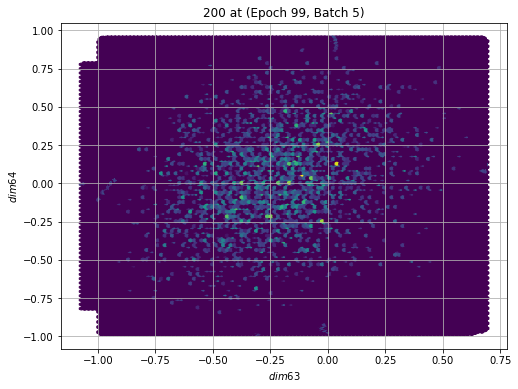

In [51]:
# Main optimization loop

all_seeds = np.linspace(1, 10, 10)
# sanity check, delete
all_seeds = [9]


# number of epochs
num_epoch = 100
# tune batch size for good generalization error
batch_size = 2**8

# loop over all random seeds to confirm working algorithm
for seed_idx in np.arange(len(all_seeds)):
    # fix a seed
    seed = int(all_seeds[seed_idx])
    # set random seed
    np.random.seed(int(seed))
    # restart NN
    ginz_flow = NormalizingFlow(dim=ginz_dim, blocks=None, flow_length=32, density=None)
    # Create optimizer algorithm
    optimizer = optim.Adam(ginz_flow.parameters(), lr=1e-3)
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9999)
    # begin training
    num_subplot = 0
    all_losses = []
    all_test_losses = []
    # save figure in individual folders for each seed
    seed_path = "./img/GL_2d/seed{}".format(seed)
    if not os.path.isdir(seed_path):
        os.mkdir(seed_path)
    for epoch in range(num_epoch):
        # # # # # # # # # #
        # Data Preproc
        # # # # # # # # # #
        permutation = torch.randperm(num_samples)
        for it in range(0, num_samples, batch_size):
            batch_number = it // batch_size
            # Draw a random sample batch from "base" (the truncated TT samples, in training data)
            sample_idx = permutation[it:it + batch_size]
            #np.random.choice(training_data.shape[0], batch_size)
            samples = torch.Tensor(training_data[sample_idx,:])
            log_base_prob = torch.Tensor(log_training_data_densities[sample_idx, :]).reshape(-1,1)

            # flow this sample
            zk, log_jacobians = ginz_flow(samples)

            # volume correction (approximate dist.)
            log_base_prob = log_base_prob.reshape(-1)
            base_prob = log_base_prob
            ### visual reporting
            if (it % 10 == 0):
                # plot the flowed samples
                num_subplot += 1
                plt.figure(2, figsize=(8,6));
                plt.grid(True); 
                plt.xlabel("$dim {}$".format(ginz_dim-1)); 
                plt.ylabel("$dim {}$".format(ginz_dim)); 
                plt.title("{} at (Epoch {}, Batch {})".format(num_subplot, epoch, batch_number));
                # pick a sample from training data, flow, and plot it
                data_idx = np.random.randint(0, training_data.shape[0], 10*num_samples)
                plot_data = torch.Tensor(training_data[data_idx, :])
                flowed_plot_data, _ = ginz_flow(plot_data)
                flowed_plot_data = flowed_plot_data.detach().numpy()
                plt.hexbin(flowed_plot_data[:,ginz_dim-2], flowed_plot_data[:,ginz_dim-1]);
                ##########
                # save figure in individual folders for each seed
                if use_gaussian_prior:
                    plt.savefig("./img/GL_2d/seed{}/seed{}_ginzburg2d_scal_gaussian_prior".format(seed, \
                                                                                                  seed) + \
                                "_batchsz{}_epoch{}_batch{}".\
                                format(batch_size, epoch, it))
                else:
                    plt.savefig("./img/GL_2d/seed{}/seed{}_ginzburg2d_tt_prior".format(seed, seed) + \
                                "_batchsz{}_epoch{}_batch{}".\
                                format(batch_size, epoch, it))

            # clean optimizer
            optimizer.zero_grad()
            # compute loss of on the flowed sample
            loss_v = loss_kl_3(base_prob, equilibrium_pdf, samples, zk, log_jacobians)
            # backprop of NN
            loss_v.backward()

            optimizer.step()
            scheduler.step()
            # compute test loss (do not use backward on this part)
            # flow all test data to evaluate loss
            samples_test = torch.Tensor(test_data)
            samples_test_likelihoods = torch.Tensor(log_test_data_densities).reshape(-1, 1)
            zk_test, log_jacobians_test = ginz_flow(samples_test)
            loss_test = loss_kl_3(samples_test_likelihoods, equilibrium_pdf, \
                                  samples_test, zk_test, log_jacobians_test)
            if batch_number % 5 == 0:
                
                print("(Epoch {}, Batch {}) Negtive Log-Likelihood Training Err: {}".format(epoch, \
                                                                                            batch_number, \
                                                                                              loss_v.item()))
                # for plotting loss
                all_losses.append(loss_v.item())
                print("(Epoch {}, Batch {}) Negtive Log-Likelihood Generalization Err: {}".format(epoch,\
                                                                                                  batch_number, \
                                                                                        loss_test.item()))
                all_test_losses.append(loss_test.item())
    # after training for this seed, output losses
    save_dict = {"seed": seed, "training_loss": all_losses, \
                 "test_loss": all_test_losses, "bc_sz: ": batch_size, \
                "num_epoch": num_epoch}
    save_filename = "./report/GL2d/seed{}_report.mat".format(seed)
    scipy.io.savemat(save_filename, save_dict)
    # after training, save model
    model_path = "./report/GL2d/seed{}_trained_model.pkl".format(seed)
    torch.save(ginz_flow, model_path)

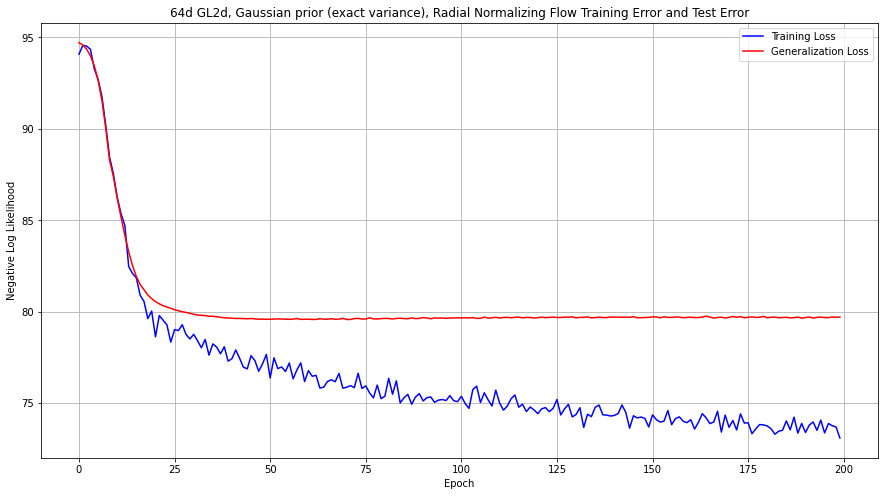

In [55]:
plt.figure(1, figsize=(15, 8))
plt.plot(all_losses, color="blue", label="Training Loss")
plt.plot(all_test_losses, color="red", label="Generalization Loss")
plt.title("64d GL2d, Gaussian prior (exact variance), Radial Normalizing Flow Training Error and Test Error")
plt.grid(True);
plt.xlabel("Epoch");
plt.ylabel("Negative Log Likelihood");
plt.legend();

In [56]:
save_filename = "./report/GL2d/seed{}_report.mat".format(seed)
scipy.io.savemat(save_filename, save_dict)

In [57]:
model_path = "./report/GL2d/seed{}_trained_model.pkl".format(seed)
torch.save(ginz_flow, model_path)